### import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle
from WeightedLDA import WeightedLDA
from shapeGMMTorch import similarities 
from shapeGMMTorch import plots

### load trajectory

In [2]:
data_path = "../iter-1/run_metad_sim/height_0.7_bf_8_sigma_0.55/analysis/"

# select atoms
sel_atoms = "(name C and resid 1) or (name C CA N and not resid 1 9) or (name N and resid 9)"
print("selected atoms:", sel_atoms)

prmtopFileName =  data_path + "left_protein_only.gro"
trajFiles = [data_path + "wt_metad_ld1_aib9_400K_height_0.7_bf_8_sigma_0.55_wrapped.xtc"]
print(trajFiles)

coord = md.Universe(prmtopFileName,trajFiles)
bb_atoms = coord.select_atoms(sel_atoms)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",bb_atoms.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)

trajData = np.empty((coord.trajectory.n_frames,bb_atoms.n_atoms,3),dtype=float)
count = 0

for ts in coord.trajectory:
    trajData[count,:,:] = bb_atoms.positions - bb_atoms.center_of_geometry()
    count += 1

selected atoms: (name C and resid 1) or (name C CA N and not resid 1 9) or (name N and resid 9)
['../iter-1/run_metad_sim/height_0.7_bf_8_sigma_0.55/analysis/wt_metad_ld1_aib9_400K_height_0.7_bf_8_sigma_0.55_wrapped.xtc']
Number of atoms in trajectory: 129
Number of frames in trajectory: 500001
Number of atoms being analyzed: 23
Number of frames being analyzed: 500001


### load from COLVAR

In [10]:
#time, ld1, metad_rbias = np.loadtxt(data_path+"../COLVAR", usecols=(0,1,3), unpack=True)
time, ld1, metad_rbias = np.loadtxt(data_path+"../COLVAR_500ns", usecols=(0,1,3), unpack=True)

time *= 1e-3 # in ns
zeta = np.loadtxt(data_path+"zeta.txt")


#wall_bias = np.sum(np.loadtxt(data_path+"../COLVAR", usecols=(-2,-1)), axis=1)
wall_bias = np.sum(np.loadtxt(data_path+"../COLVAR_500ns", usecols=(-2,-1)), axis=1)

In [11]:
print(data_path)

../iter-1/run_metad_sim/height_0.7_bf_8_sigma_0.55/analysis/


### plot the bias 

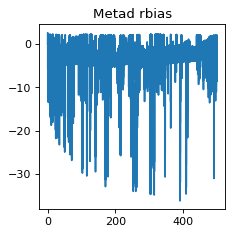

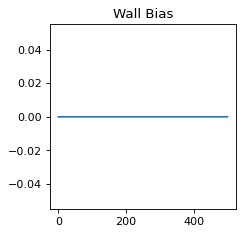

In [12]:
plt.figure(figsize=(3,3), dpi=80)
plt.title("Metad rbias", fontsize=12)
plt.plot(time, metad_rbias)

plt.figure(figsize=(3,3), dpi=80)
plt.title("Wall Bias", fontsize=12)
plt.plot(time, wall_bias)

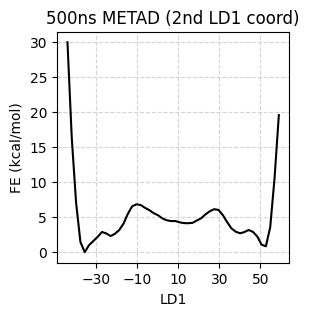

In [13]:
kbt = 0.794882 # from PLUMED at 400.0K
num_bins = 50
range_ = [-45,60]

# histogram
hist, edges = np.histogram(ld1, bins=num_bins, range=range_, density=True, weights=np.exp(metad_rbias/kbt))
bins = (edges[1:]+edges[:-1])/2
fe = -kbt*np.log(hist)
fe -= fe.min()

# plot
plt.figure(figsize=(3,3))
plt.title("500ns METAD (2nd LD1 coord)")
plt.ylabel("FE (kcal/mol)")
plt.xticks(np.arange(-50,70, 20))
plt.xlabel("LD1")
plt.grid(axis="both", which="major", linestyle="--", color="lightgrey")
plt.plot(bins, fe, 'k-')

### plot LD and $\zeta$

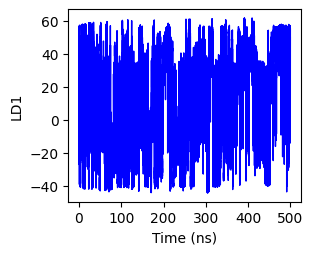

In [14]:
plt.figure(figsize=(3,2.5))
plt.xticks(np.arange(0,600,100))
plt.xlabel("Time (ns)")
plt.ylabel("LD1")
plt.plot(time, ld1, 'b-', lw=1.0)

In [16]:
print(min(ld1), max(ld1))
print(trajData.shape, metad_rbias.shape, ld1.shape, time.shape, zeta.shape)

-44.4412366 61.80455166
(500001, 23, 3) (500001,) (500001,) (500001,) (500001,)


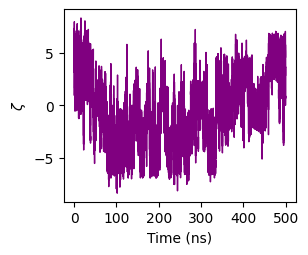

In [17]:
plt.figure(figsize=(3,2.5))
plt.xticks(np.arange(0,600,100))
plt.xlabel("Time (ns)")
plt.ylabel("$\zeta$")
plt.plot(time, zeta, ls="-", color="purple", lw=1.0)

### select the data and calculate weights

In [18]:
stride_ = 5  ## every 5 frame

trajData = trajData[::stride_,:,:]
time = time[::stride_]
metad_rbias = metad_rbias[::stride_]
ld1 = ld1[::stride_]
zeta = zeta[::stride_]

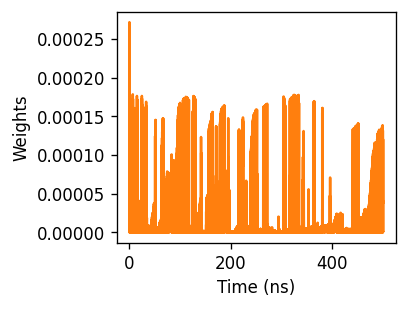

In [19]:
kt = 0.794882 # from PLUMED at 400.0K
weights = np.exp(metad_rbias/kt)  ## wall_bias = 0.0 for all chosen frames i.e. why not included
weights /=  np.sum(weights)

plt.figure(figsize=(3,2.5), dpi=120)
plt.xlabel("Time (ns)")
plt.ylabel("Weights")
plt.plot(time, weights, '-', color="tab:orange")

### perform cluster scan 

In [20]:
# define cluster array
cluster_array = np.arange(2,8,1).astype(int)
print(cluster_array)

[2 3 4 5 6 7]


In [15]:
# perform cluster scan on this data (use 90% data for training)
#train, cv = scripts.cross_validate_cluster_scan(trajData, 90000, frame_weights = weights, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=4, n_attempts = 10, dtype=torch.float64, device=torch.device("cuda:0"))

Number of frames to train each model: 90000
Number of frames to predict each model: 10001
Number of training sets: 4
Number of clusters: 6
Number of attempts per set/cluster: 10
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               2               1              90.058          44.973
              1               2               2              90.060          37.926
              1               2               3              90.674          43.634
              1               2               4              89.941          37.765
              1               2               5              88.997          42.613
              1               2               6              90.050          29.773
              1               2               7              90.054          44.200
              1               2               8              90.8

              2               5               5              99.510          65.973
              2               5               6              99.811          46.270
              2               5               7             102.048          70.280
              2               5               8             101.607          20.954
              2               5               9             100.806          82.565
              2               5              10             100.897          69.695
              2               6               1             101.909          53.986
              2               6               2             103.407          75.935
              2               6               3             102.491          34.855
              2               6               4             103.015          27.011
              2               6               5             103.230          50.754
              2               6               6             102.852         

              4               3               3              94.658          22.280
              4               3               4              95.209          52.643
              4               3               5              93.571          22.813
              4               3               6              93.657          57.375
              4               3               7              94.703          50.177
              4               3               8              95.080          54.161
              4               3               9              96.323          25.130
              4               3              10              94.870          41.263
              4               4               1              97.718          17.201
              4               4               2              96.843          72.372
              4               4               3              97.048          57.793
              4               4               4              99.383         

In [21]:
train = np.loadtxt("train.dat")[:,1:]
cv = np.loadtxt("cv.dat")[:,1:]

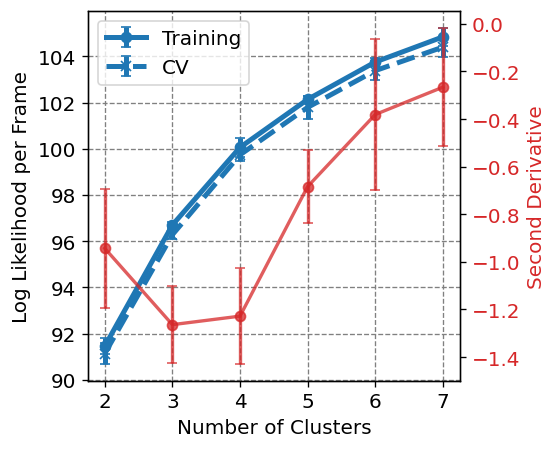

In [22]:
# shapeGMMTorch plots has a built-in plot function for this type of plot
fig, ax = plt.subplots(1,1,figsize=(4,4), dpi= 120, facecolor='w', edgecolor='k')
plots.plot_log_likelihood_with_dd(ax,cluster_array, train, cv, fontsize=12, ylabel1=True, ylabel2=True, xlabel=True)

## 3 clusters

In [18]:
#wsgmm = scripts.sgmm_fit_with_attempts(trajData, 3, 20, weights, device=torch.device("cuda:0"), dtype=torch.float64)

#with open("wsgmm_3states.pickle", "wb")as f_o:
#    pickle.dump(wsgmm, f_o)

Number of training frames: 100001
Number of clusters: 3
Number of attempts: 20
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              94.837          63.833
       2              95.952          32.604
       3              93.683          62.034
       4              95.851          41.368
       5              96.078          26.456
       6              95.283          62.211
       7              94.828          63.312
       8              94.457          65.030
       9              94.686          65.361
      10              95.589          63.236
      11              96.305          51.442
      12              95.120          64.619
      13              95.102          57.975
      14              95.404          52.018
      15              96.230          61.572
      16              95.694          61.184
      17              95.330          41.300
      18              94.637          62.023
      19       

## 4 clusters

In [19]:
#wsgmm = scripts.sgmm_fit_with_attempts(trajData, 4, 20, weights, device=torch.device("cuda:0"), dtype=torch.float64)

#with open("wsgmm_4states.pickle", "wb")as f_o:
#    pickle.dump(wsgmm, f_o)

Number of training frames: 100001
Number of clusters: 4
Number of attempts: 20
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              99.101          75.338
       2              99.237          77.021
       3              98.564          60.232
       4              99.475          74.133
       5              99.995          56.631
       6              97.096          78.461
       7              97.885          18.645
       8              98.535          77.500
       9              98.810          52.323
      10              95.929          73.918
      11              99.355          60.451
      12              99.690          69.590
      13              98.960          62.154
      14              97.558          61.994
      15              97.681          79.470
      16              97.261          64.572
      17              98.406          29.687
      18              98.730          48.294
      19       

### load all the objects 

In [23]:
wsgmm_list = []
for i in [3,4]:
    with open("wsgmm_%dstates.pickle"%i, "rb") as fo:
        wsgmm = pickle.load(fo)
    wsgmm_list.append(wsgmm)

In [24]:
print(wsgmm_list[0].weights)
print(wsgmm_list[0].cluster_ids.shape)

print(wsgmm_list[1].weights)
print(wsgmm_list[1].cluster_ids.shape)

[0.48531268 0.28909953 0.22558778]
(100001,)
[0.43290843 0.22537215 0.18594073 0.15577868]
(100001,)


### Check the bhattacharya distances for cluster centers w.r.t. initial clusters

$\textbf{load initial object from wt-metad of posLDA paper}$

c= 0 is left helix and c= 1 is right helix.

In [25]:
path_to_ref_gmm = "/scratch/projects/hockygroup/ss12902/aib9_sGMM_torch/"
with open(path_to_ref_gmm+"wsgmm.pickle", "rb") as fo:
    wsgmm_ref = pickle.load(fo)

In [26]:
dist_data = []

# loop over objects [3,4]
for i in range(2):
    
    vals = []
    # loop over number of clusters
    for j in range(wsgmm_list[i].n_clusters):
        
        # wrt 0
        dij_0 = similarities.bhattacharyya_distance(wsgmm_list[i], j, wsgmm_ref, 0)
        
        # wrt 1
        dij_1 = similarities.bhattacharyya_distance(wsgmm_list[i], j, wsgmm_ref, 1)
        
        vals.append([dij_0, dij_1])
        
    #dist_data.append(np.array(vals))
    dist_data.append(np.log(np.array(vals)))     # take log y

In [27]:
print(dist_data)

[array([[ 6.65071679, -0.02188982],
       [ 2.33552179,  2.26294469],
       [ 1.38323648,  5.198488  ]]), array([[ 6.92870188, -0.44422284],
       [ 2.19046583,  1.99704574],
       [ 0.46868055,  6.34795439],
       [ 2.48645416,  2.34591369]])]


In [28]:
# save log(b-dist)
np.savetxt('logb-dist.txt', dist_data[0])

### 3 clusters

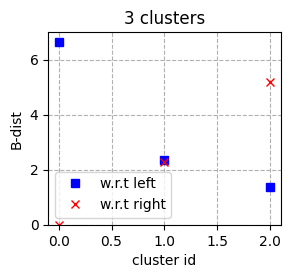

In [22]:
plt.figure(figsize=(3,2.5))
plt.xlabel("cluster id")
plt.ylabel("B-dist")
plt.grid(linestyle="--")
plt.title("3 clusters")
plt.ylim(0,7)
wsgmm3 = wsgmm_list[0]
for i in range(wsgmm3.n_clusters):
    x = plt.plot(i, dist_data[0][i,0], 's', color="b", label="w.r.t left" if i == 0 else "")
    y = plt.plot(i, dist_data[0][i,1], 'x', color="r", label="w.r.t right" if i == 0 else "")
plt.legend()

-5.396088071527648
-0.26606257512296766
3.0513270628686655


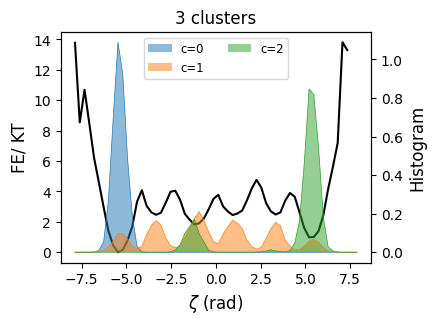

In [23]:
wsgmm3 = wsgmm_list[0]

range_ = [-8.0,8.0]
nbins = 60
hist, edges = np.histogram(zeta, range=range_, bins=nbins, density=True, weights=weights)
bins = (edges[1:]+edges[:-1])/2.0
fe = -np.log(hist)
fe -= fe.min()

fig, ax =plt.subplots(1, 1, figsize=(4,3))
plt.title("3 clusters")
ax.set_ylabel("FE/ KT", fontsize=12)
ax.set_xlabel("$\zeta$ (rad)", fontsize=12)
ax.plot(bins, fe, 'k-')
ax_inv  =ax.twinx()
ax_inv.set_ylabel("Histogram", fontsize=12)
for i in range(3):
    zeta_i = zeta[[x[0] for x in np.argwhere(wsgmm3.cluster_ids == i)]]
    print(np.mean(zeta_i))
    H, _ = np.histogram(zeta_i, range=range_, bins=nbins, density=True, weights=weights[[x[0] for x in np.argwhere(wsgmm3.cluster_ids == i)]])
    ax_inv.fill_between(bins, H, alpha=0.5, label="c=%d"%i)
    ax_inv.plot(bins, H, lw=0.5)
ax_inv.legend(ncol=2, loc="upper center", fontsize="small")

### 4 clusters

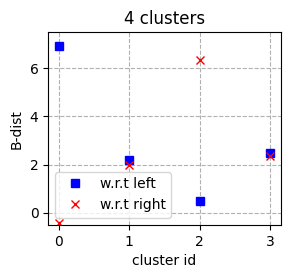

In [24]:
plt.figure(figsize=(3,2.5))
plt.xlabel("cluster id")
plt.ylabel("B-dist")
plt.grid(linestyle="--")
plt.title("4 clusters")
plt.ylim(-0.5,7.5)
wsgmm4 = wsgmm_list[1]
for i in range(wsgmm4.n_clusters):
    x = plt.plot(i, dist_data[1][i,0], 's', color="b", label="w.r.t left" if i == 0 else "")
    y = plt.plot(i, dist_data[1][i,1], 'x', color="r", label="w.r.t right" if i == 0 else "")
plt.legend()

-5.411754711219833
-0.007363934804361763
4.757009552326679
-0.5007739829698395


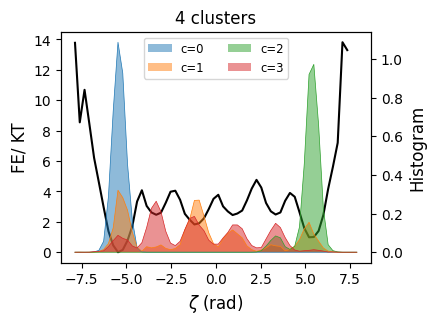

In [25]:
wsgmm4 = wsgmm_list[1]

range_ = [-8.0,8.0]
nbins = 60
hist, edges = np.histogram(zeta, range=range_, bins=nbins, density=True, weights=weights)
bins = (edges[1:]+edges[:-1])/2.0
fe = -np.log(hist)
fe -= fe.min()

fig, ax =plt.subplots(1, 1, figsize=(4,3))
plt.title("4 clusters")
ax.set_ylabel("FE/ KT", fontsize=12)
ax.set_xlabel("$\zeta$ (rad)", fontsize=12)
ax.plot(bins, fe, 'k-')
ax_inv  =ax.twinx()
ax_inv.set_ylabel("Histogram", fontsize=12)
for i in range(4):
    zeta_i = zeta[[x[0] for x in np.argwhere(wsgmm4.cluster_ids == i)]]
    print(np.mean(zeta_i))
    H, _ = np.histogram(zeta_i, range=range_, bins=nbins, density=True, weights=weights[[x[0] for x in np.argwhere(wsgmm4.cluster_ids == i)]])
    ax_inv.fill_between(bins, H, alpha=0.5, label="c=%d"%i)
    ax_inv.plot(bins, H, lw=0.5)
ax_inv.legend(ncol=2, loc="upper center", fontsize="small")

### Global Alignment of trajectory 

In [27]:
from shapeGMMTorch import torch_align

traj_tensor = torch.tensor(trajData, dtype=torch.float)
wgts_tensor = torch.tensor(weights)

# weighted alignment of biased trajectory (using weights)
global_aligned_traj, global_avg, global_prec, global_lpdet = torch_align.torch_iterative_align_kronecker_weighted(traj_tensor, wgts_tensor, device=torch.device("cpu"), max_iter=750)

np.savetxt("global_avg.txt", global_avg)
np.savetxt("global_prec.txt", global_prec)
np.save("global_aligned_traj.npy", global_aligned_traj, allow_pickle=True)

### We are going to choose 3-state fit 

For 3 clusters ->
1. c=0 is closest to right state
2. c=2 is closest to left state 

In [37]:
c0_indx = [x[0] for x in np.argwhere(wsgmm3.cluster_ids == 0)]   # right 
c2_indx = [x[0] for x in np.argwhere(wsgmm3.cluster_ids == 2)]   # left 

print(len(c0_indx), len(c2_indx))

8295 8444


In [38]:
c0_traj = global_aligned_traj[c0_indx,:,:]   # close to right
c2_traj = global_aligned_traj[c2_indx,:,:]   # close to left

comb_traj = np.concatenate([c2_traj, c0_traj], axis=0)
labels = np.concatenate([np.zeros(len(c2_indx)), np.ones(len(c0_indx))], axis=0)

print(comb_traj.shape, labels.shape)

(16739, 23, 3) (16739,)


### perform weighted LDA 

In [39]:
from WeightedLDA import WeightedLDA as WL

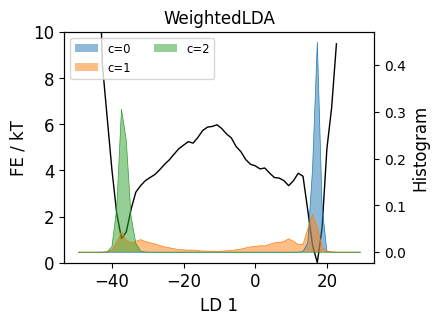

In [47]:
ld_range = (-50,30)
nbins = 60

fig, ax = plt.subplots(1, 1, figsize=(4,3)) 

ax.set_title("WeightedLDA", fontsize=12)
ax.set_ylabel("FE / kT",fontsize=12)
ax.set_xlabel("LD 1", fontsize=12)
ax.tick_params(axis='both',labelsize=12)
ax.set_ylim(0,10.0)

# lda calculation
lda = WL.WeightedLDA()

# get weights for left and right helix only
sel_weights = np.concatenate([weights[c2_indx], weights[c0_indx]], axis=0)

lda.fit(comb_traj.reshape(comb_traj.shape[0], comb_traj.shape[1]*3), labels, wgts=sel_weights)
ld1_all = lda.transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], global_aligned_traj.shape[1]*3))[:,0]

# histogramming the lda and calculate free energy
hist, bins = np.histogram(ld1_all, range=ld_range, bins=nbins, density=True, weights=weights)
fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2
ax.plot(grids, fe-fe.min(), lw=1.0, color="k")

ax_inv = ax.twinx()
ax_inv.set_ylabel("Histogram", fontsize=12)
for i in range(3):
    ld_i = ld1_all[[x[0] for x in np.argwhere(wsgmm3.cluster_ids == i)]]
    H, _ = np.histogram(ld_i, range=ld_range, bins=nbins, density=True, weights=weights[[x[0] for x in np.argwhere(wsgmm3.cluster_ids == i)]])

    ax_inv.fill_between(grids, H, alpha=0.5, label="c=%d"%i)
    ax_inv.plot(grids, H, lw=0.5)
    
ax_inv.legend(ncol=2, loc="upper left", fontsize="small")

In [51]:
print(kt)
print(max(ld1_all), min(ld1_all))

0.794882
22.13663779751551 -43.58694188970534


In [49]:
# save the lda coefficients
#np.savetxt("ld1_3states_scalings.txt", lda.scalings_[:,0])

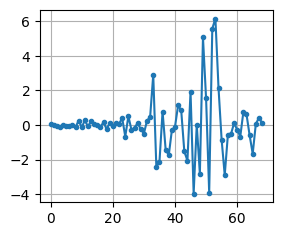

In [50]:
plt.figure(figsize=(3,2.5))
plt.grid()
plt.plot(lda.scalings_[:,0], '.-')

In [56]:
# calculating the standard deviation of LD coord from left helical state 
print(np.std(ld1_all[c2_indx]))
print(np.std(ld1_all[c2_indx])/2)
print(np.std(ld1_all[c2_indx])/3)

1.440410472278525
0.7202052361392625
0.48013682409284164


In [57]:
print(bb_atoms.indices+1)

[ 18  20  22  31  33  35  44  46  48  57  59  61  70  72  74  83  85  87
  96  98 100 109 111]
